# COGS 108 - EDA Checkpoint

# Names

- Anna Wang
- Chloe Salem
- Kristy Liou
- Maxtierney Arias
- Zeven Vidmar Barker

<a id='research_question'></a>
# Research Question

Can we predict which state in the USA will be covid-free first based on current hospital records, state regulations, and population?

# Setup

In [1]:
## YOUR CODE HERE
#importing needed libraries
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime

# reading data sets
population = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/national/totals/nst-est2020.csv")
vaccinations = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
case_tracking = pd.read_csv('https://covidtracking.com/data/download/all-states-history.csv')
state_code = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')

# Data Cleaning

First with the populations dataset, we took out all of the columns except the name and estimated population for 2020. Then the vaccination and case tracking datasets, we also took out unecessary columns that we think would not help us answer our question. Then we took a state code dataset to help us match the state columns of vaccinations and case tracking. We also got rid of rows that contained information of the territories of the US. Finally we merged the vaccination and case tracking dataset into one.

In [2]:
# Removed unnecessary columns in Population dataframe
population = population[5::]
population = population[['NAME', 'POPESTIMATE2020']]
population.rename(columns={"NAME": "state", "POPESTIMATE2020": "2020 population"}, errors="raise", inplace=True)
#population.set_index(['NAME'], inplace=True)
#population.set_index(['NAME'], inplace=True)

population.head()

,state,2020 population
5,Alabama,4921532
6,Alaska,731158
7,Arizona,7421401
8,Arkansas,3030522
9,California,39368078


In [3]:
# Removed unnecessary columns in vaccinations and renamed for easier readability 
vaccinations = vaccinations.drop(['daily_vaccinations_per_million', 'share_doses_used', 'daily_vaccinations_per_million', 'share_doses_used'], 1)
new_names = []
for col in vaccinations.columns:
    new_names.append(col.replace('_', ' '))
vaccinations.rename(columns=dict(zip(vaccinations.columns, new_names)), inplace=True)

In [4]:
case_tracking.columns

Index(['date', 'state', 'death', 'deathConfirmed', 'deathIncrease',
       'deathProbable', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'negative', 'negativeIncrease',
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',
       'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently',
       'positive', 'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral', 'totalTestsViralIncrease'

In [5]:
# Dropping more unrelated columns to research question - including deaths, antibody tests, negative results, and positive results related to type of test
case_tracking = case_tracking[['date', 'state', 'hospitalized', 'hospitalizedCumulative', 'hospitalizedCurrently', 'hospitalizedIncrease', 'positive', 'recovered', 'totalTestEncountersViralIncrease', 'totalTestResults', 'totalTestResultsIncrease', 'positiveCasesViral', 'positiveIncrease']]
new_names = []
for name in case_tracking.columns:
    new_names.append((re.sub(r"(\w)([A-Z])", r"\1 \2", name)).lower())
case_tracking.rename(columns=dict(zip(case_tracking.columns, new_names)), inplace=True)

In [6]:
case_tracking.head()

,date,state,hospitalized,hospitalized cumulative,hospitalized currently,hospitalized increase,positive,recovered,total test encounters viral increase,total test results,total test results increase,positive cases viral,positive increase
0,2021-02-24,AK,1260.0,1260.0,46.0,0,55736.0,NaN,0,1662156.0,8731,NaN,176
1,2021-02-24,AL,45250.0,45250.0,773.0,0,490220.0,275245.0,0,2269033.0,3947,383882.0,1247
2,2021-02-24,AR,14649.0,14649.0,545.0,32,317396.0,307306.0,0,2618676.0,8839,250725.0,803
3,2021-02-24,AS,NaN,NaN,NaN,0,0.0,NaN,0,2140.0,0,NaN,0
4,2021-02-24,AZ,57156.0,57156.0,1449.0,84,811968.0,NaN,0,7512395.0,34072,757353.0,1310


In [7]:
vaccinations.head()

,date,location,total vaccinations,total distributed,people vaccinated,people fully vaccinated per hundred,total vaccinations per hundred,people fully vaccinated,people vaccinated per hundred,distributed per hundred,daily vaccinations raw,daily vaccinations
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.44,7.69,NaN,NaN
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.52,7.73,5906.0,5906.0
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.27,2.05,13488.0,1.77,9.07,8267.0,7478.0
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0


In [8]:
# Converting case-tracker state from Abbreviation
for i,j in state_code.iterrows():
    state_code.loc[i]['Abbreviation']
    case_tracking.loc[case_tracking.state == state_code.loc[i]['Abbreviation'], ['state']] = state_code.loc[i]['State']

# Removing the US territory data from the datasets
territories = ['AS', 'GU', 'MP', 'VI', 'PR', 'American Samoa', 
               'Federated States of Micronesia', 'Indian Health Svc', 'Guam','Long Term Care',
               'Virgin Islands','Veterans Health', 'Republic of Palau','Puerto Rico', 'Bureau of Prisons',
             'Marshall Islands','Northern Mariana Islands','Dept of Defense','United States']
case_tracking = case_tracking[~case_tracking.state.isin(territories)]
vaccinations = vaccinations[~vaccinations.location.isin(territories)]
vaccinations.loc[vaccinations.location == 'New York State', ['location']] = 'New York'

# Checking if case_tracking and vaccinations have the same states
for i in case_tracking['state'].unique():
    if i not in vaccinations['location'].unique():
        print(i)
vaccinations.rename(columns={'location':'state'},inplace=True)

# Joining case_tracking and vaccination dataframes into one
merged_data = pd.merge(case_tracking, vaccinations, on = ['date', 'state'], how='left')

merged_data.head(-1)

,date,state,hospitalized,hospitalized cumulative,hospitalized currently,hospitalized increase,positive,recovered,total test encounters viral increase,total test results,...,total vaccinations,total distributed,people vaccinated,people fully vaccinated per hundred,total vaccinations per hundred,people fully vaccinated,people vaccinated per hundred,distributed per hundred,daily vaccinations raw,daily vaccinations
0,2021-02-24,Alaska,1260.0,1260.0,46.0,0,55736.0,NaN,0,1662156.0,...,243650.0,315765.0,156027.0,11.90,33.31,87061.0,21.33,43.16,3723.0,7148.0
1,2021-02-24,Alabama,45250.0,45250.0,773.0,0,490220.0,275245.0,0,2269033.0,...,839703.0,1138650.0,591009.0,5.04,17.13,247024.0,12.05,23.22,24595.0,27098.0
2,2021-02-24,Arkansas,14649.0,14649.0,545.0,32,317396.0,307306.0,0,2618676.0,...,554466.0,816730.0,378225.0,5.72,18.37,172653.0,12.53,27.06,14274.0,9645.0
3,2021-02-24,Arizona,57156.0,57156.0,1449.0,84,811968.0,NaN,0,7512395.0,...,1555942.0,1977925.0,1137371.0,5.67,21.38,412825.0,15.63,27.17,30148.0,55863.0
4,2021-02-24,California,NaN,NaN,6764.0,0,3455361.0,NaN,0,47652172.0,...,7876011.0,10702330.0,5649200.0,5.50,19.93,2173394.0,14.30,27.09,147891.0,221857.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18428,2020-01-18,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18429,2020-01-17,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18430,2020-01-16,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18431,2020-01-15,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='2020 population', ylabel='Count'>

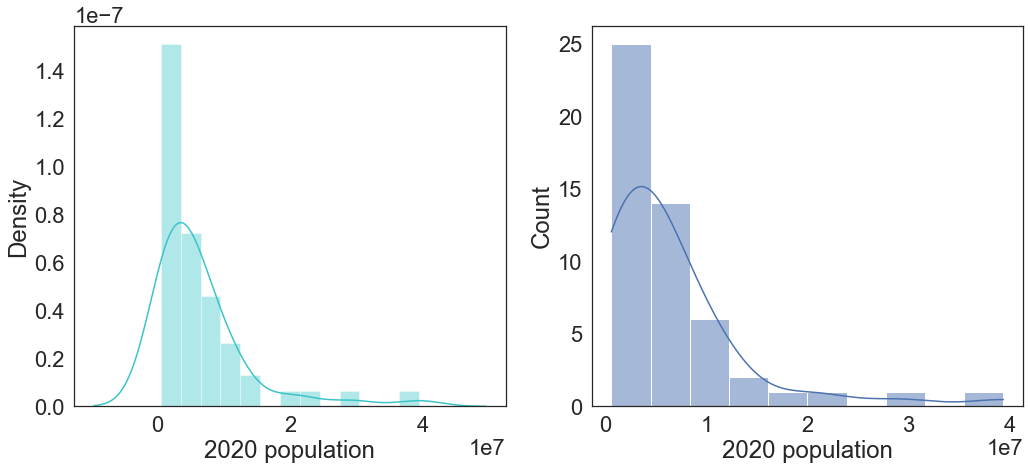

In [9]:
sns.set(style="white", font_scale=2)
plt.rcParams['figure.figsize'] = (17, 7)

plt.subplot(1, 2, 1)
sns.distplot(population['2020 population'], color='#3BC4C7');
plt.subplot(1, 2, 2)
sns.histplot(population['2020 population'], bins=10, kde=True)

<AxesSubplot:xlabel='2020 population', ylabel='state'>

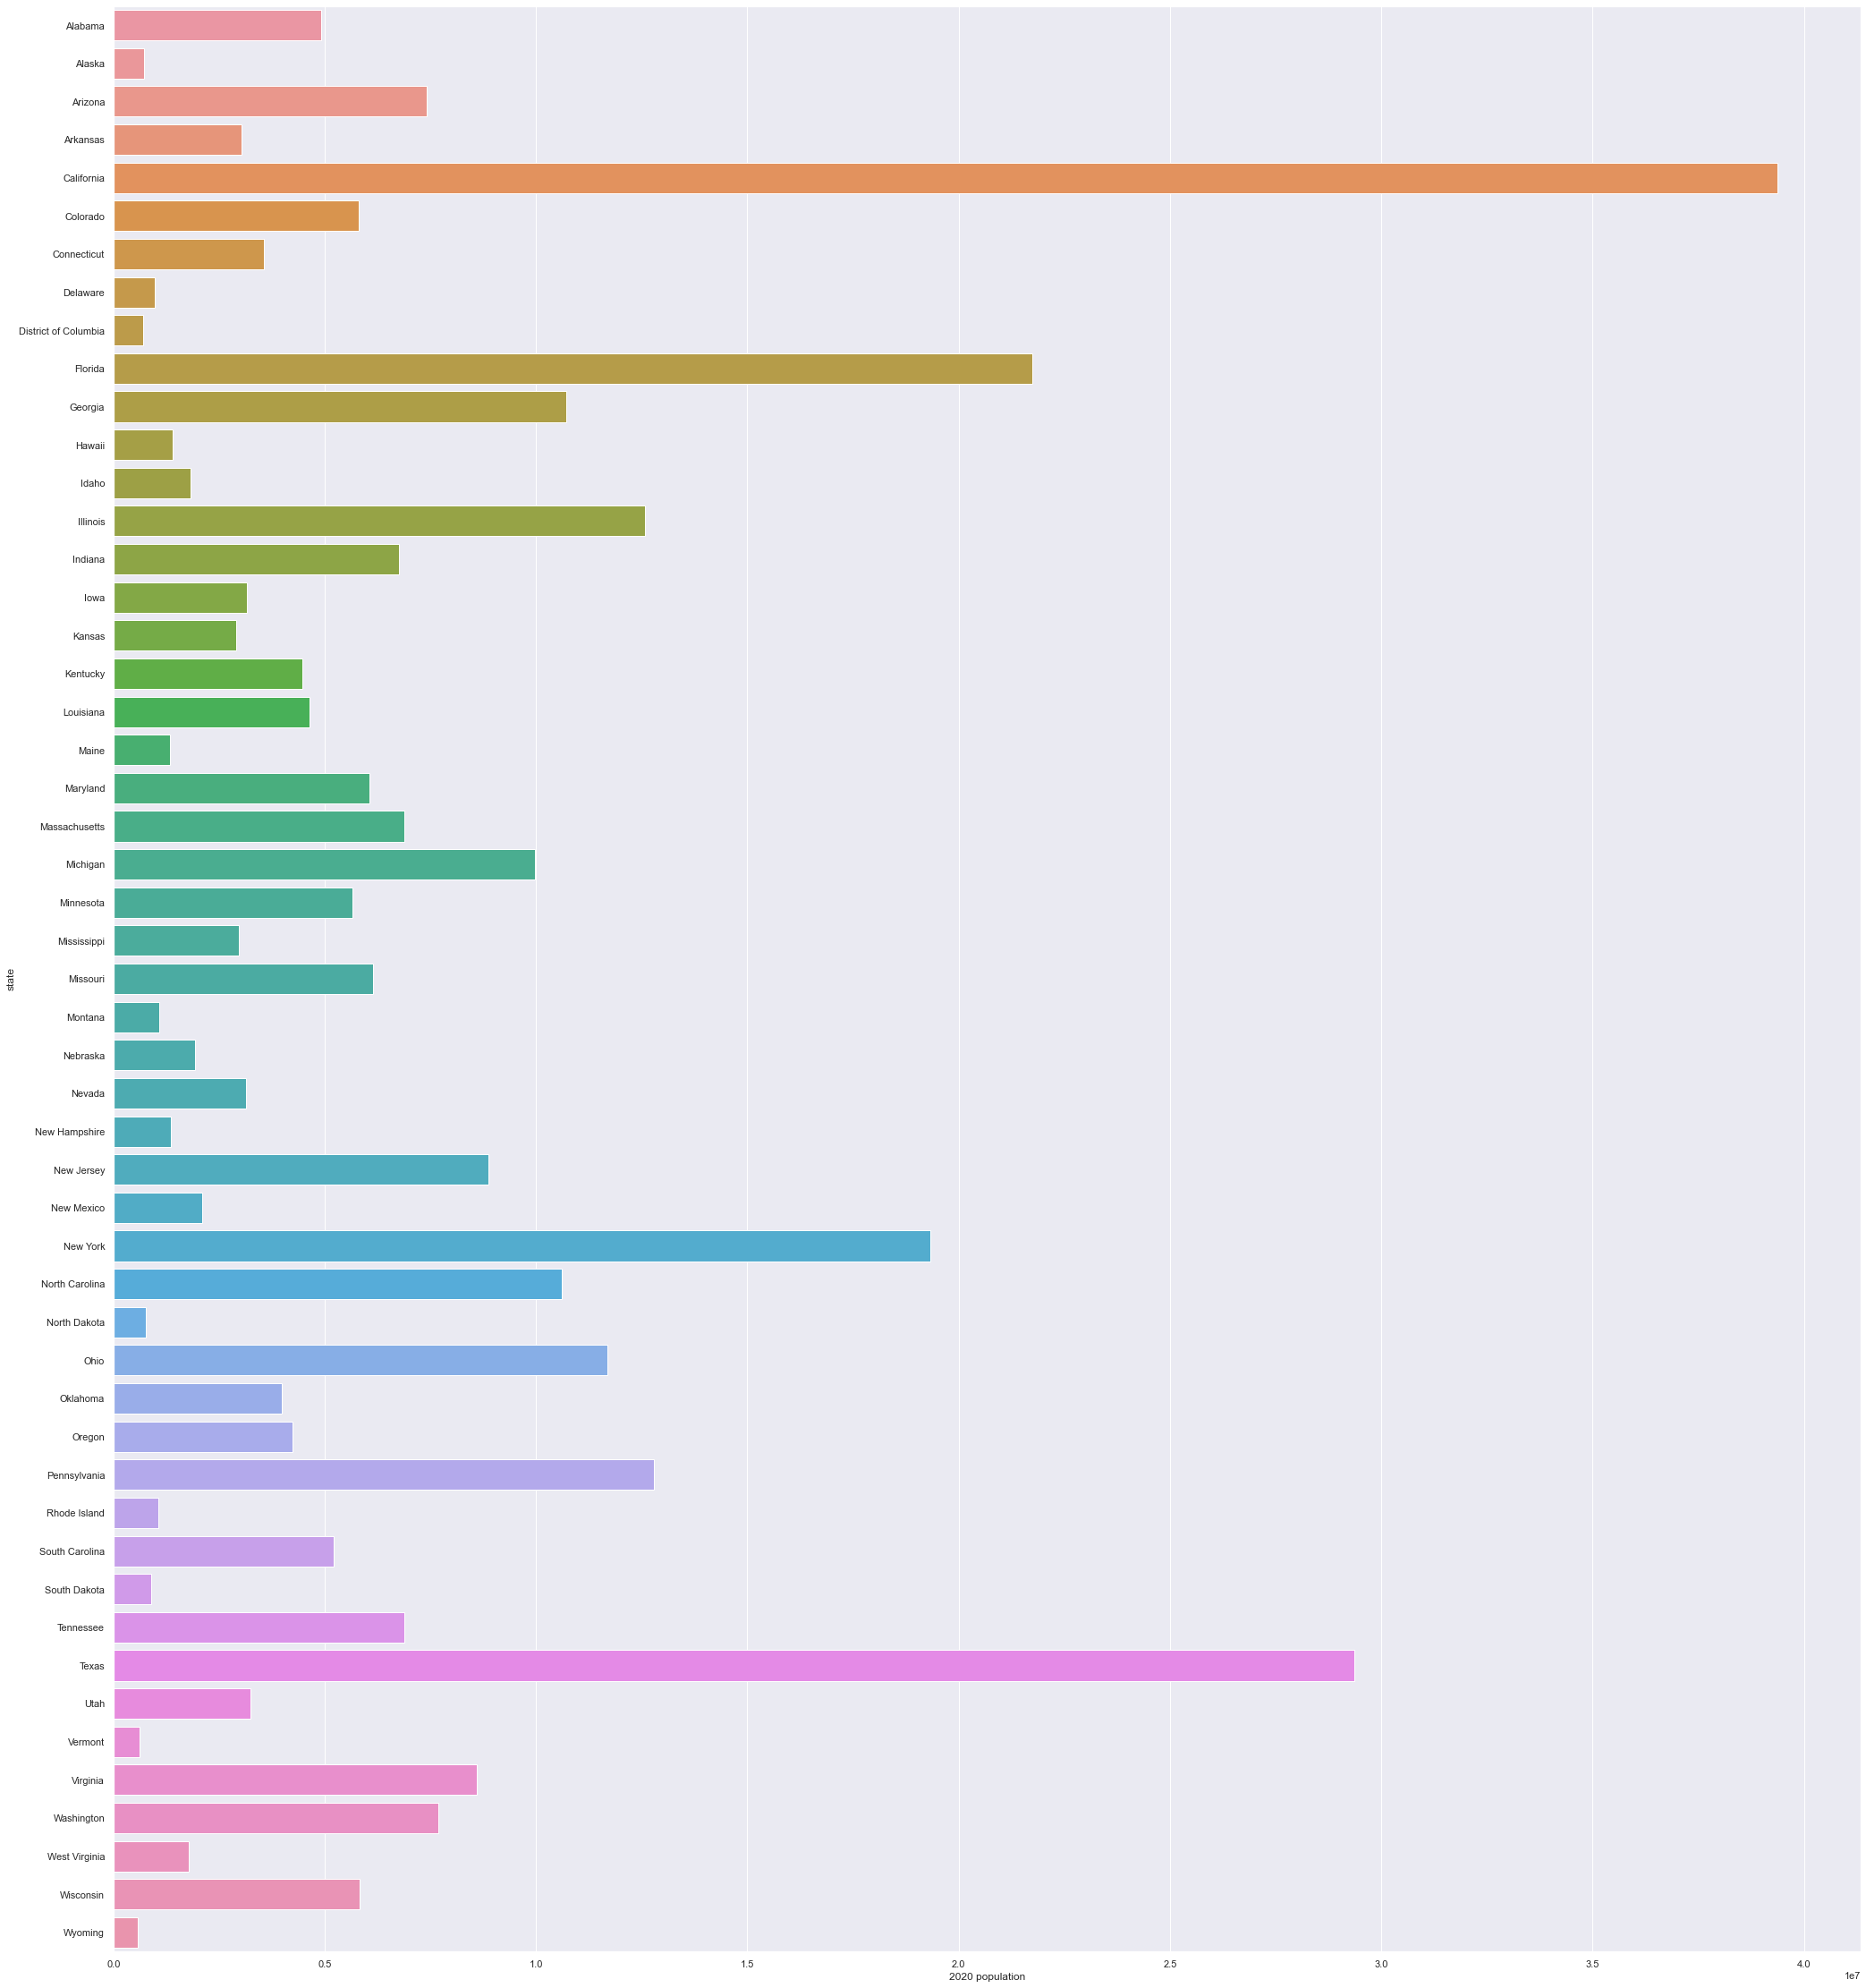

In [10]:
sns.set(rc={'figure.figsize':(35,40)})
sns.barplot(x=population['2020 population'], y='state', data=population)

In [11]:
most_recent = merged_data[merged_data['date'] == '2021-02-23']
most_recent = pd.merge(most_recent, population, on = ['state'], how='left')
most_recent['proportion vaccination'] = most_recent['people vaccinated']/most_recent['2020 population']

<AxesSubplot:xlabel='proportion vaccination', ylabel='state'>

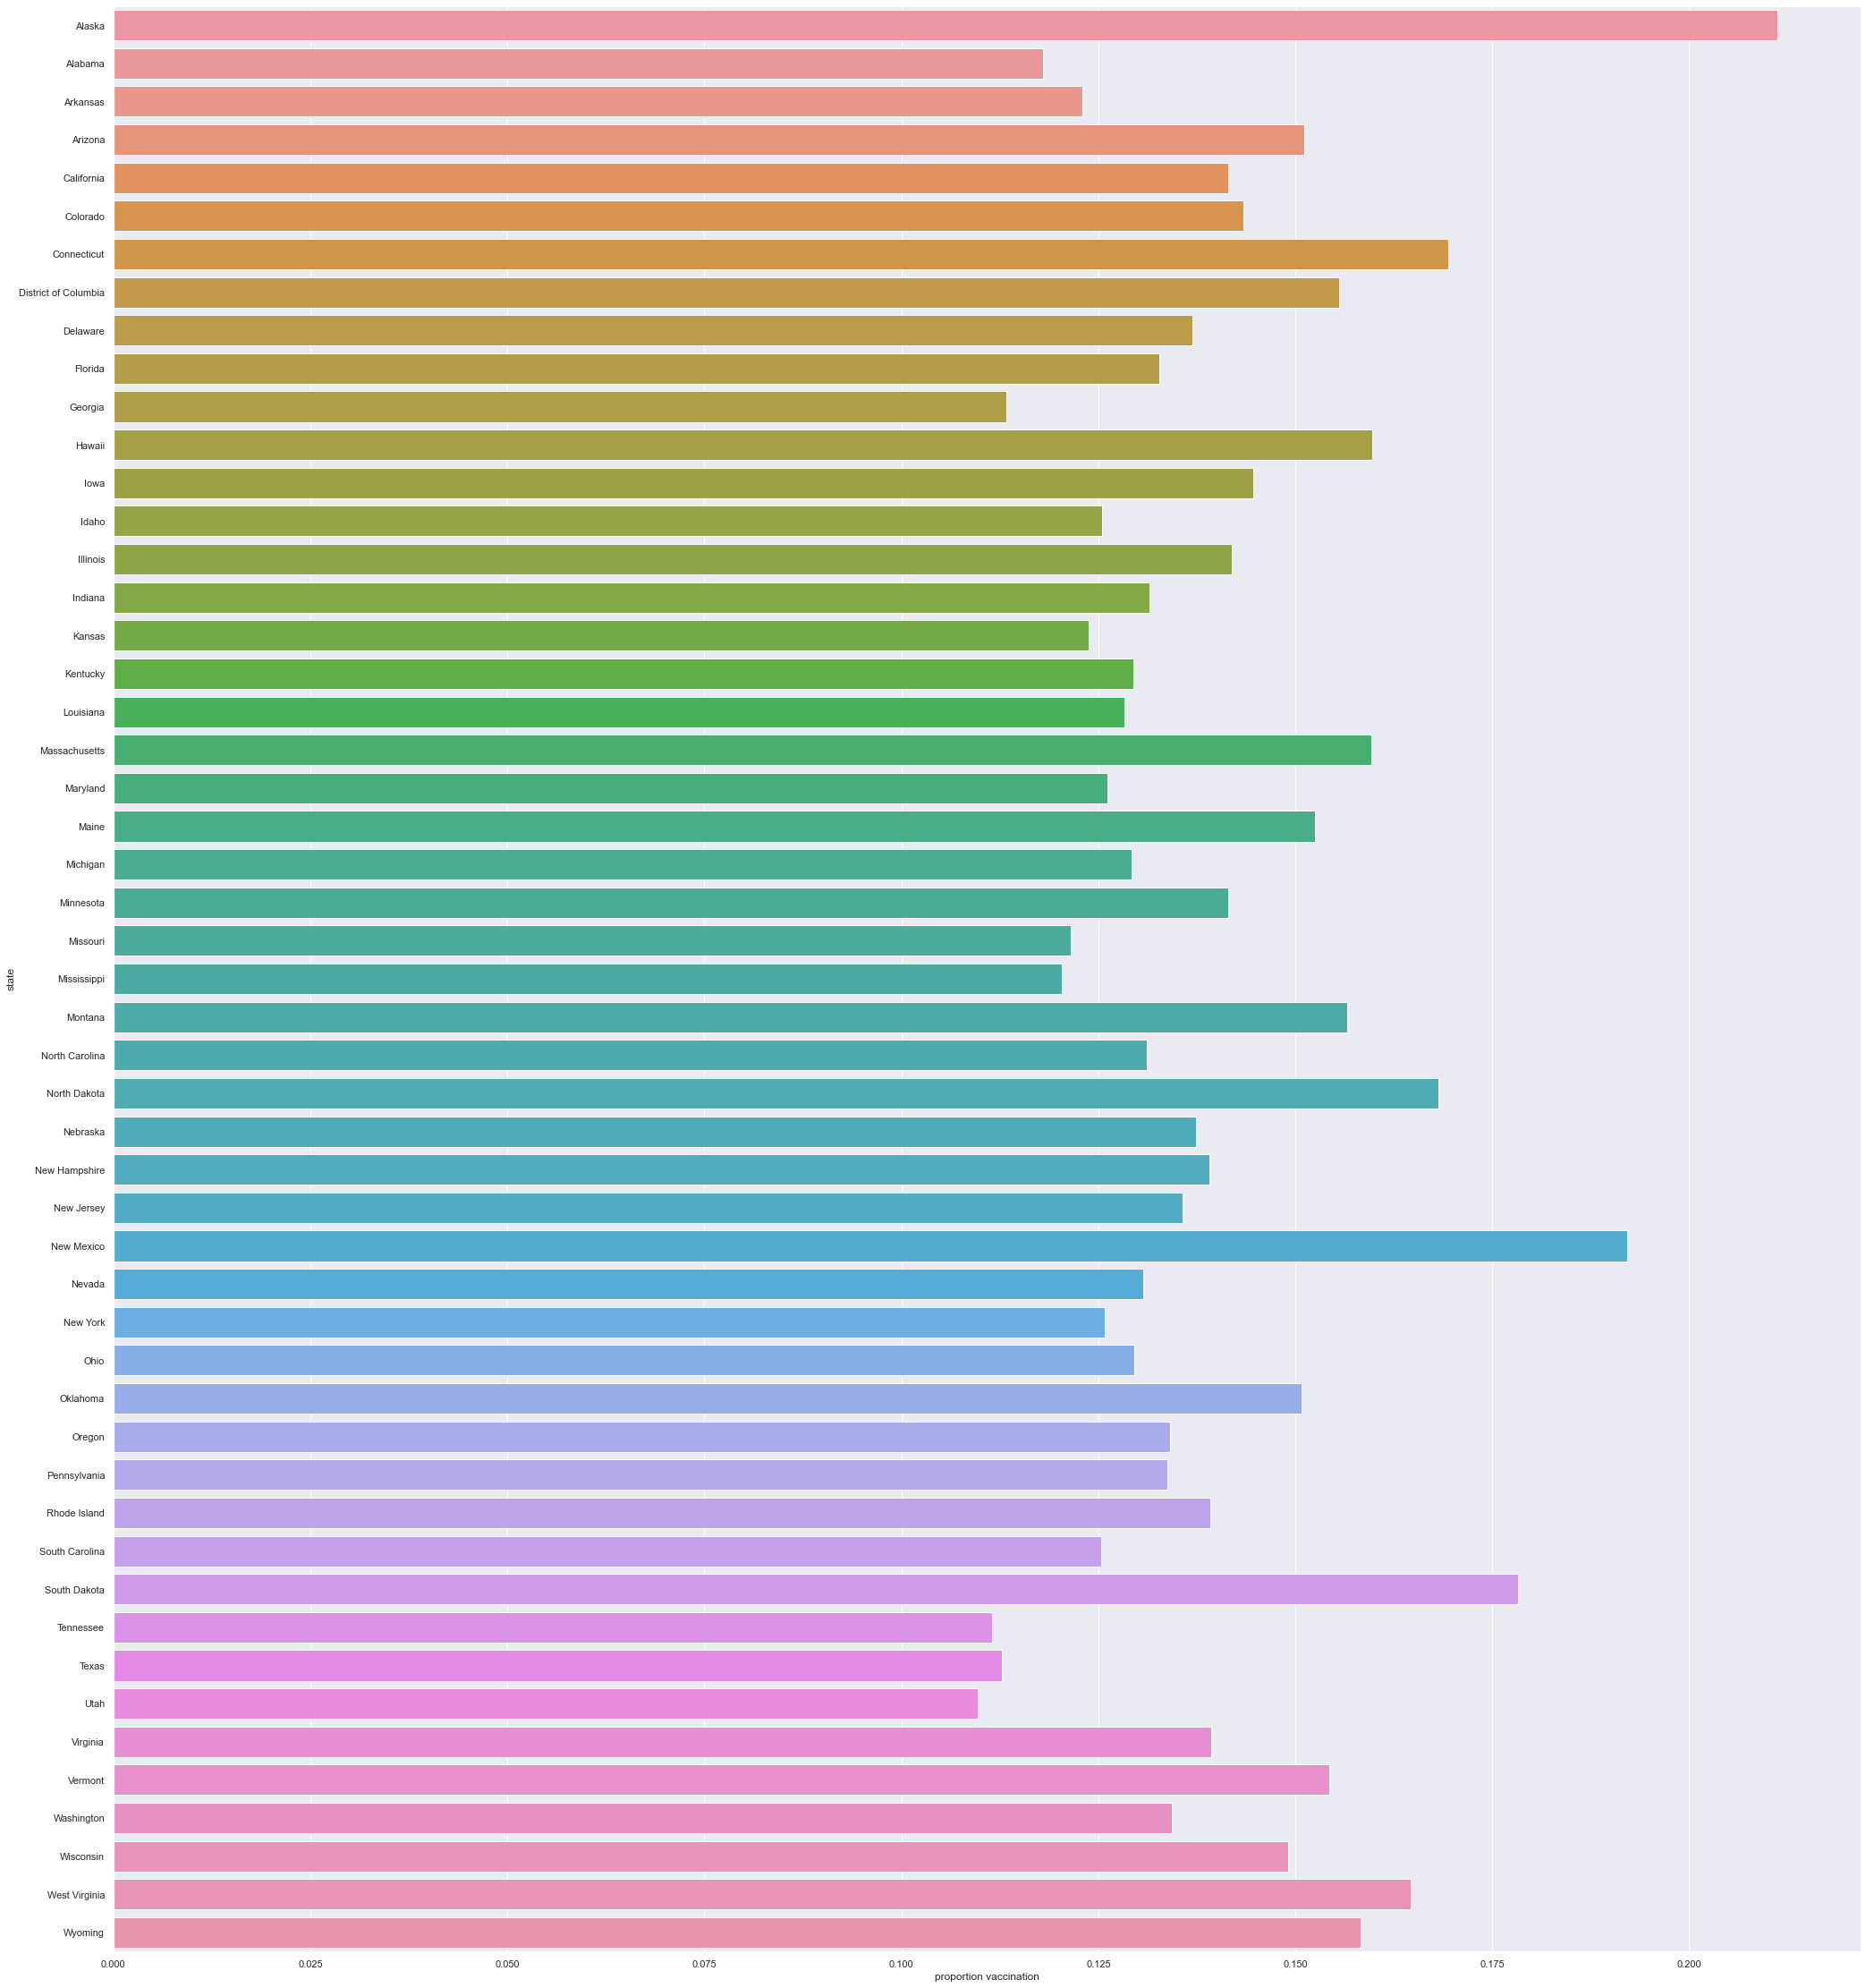

In [12]:
sns.set(rc={'figure.figsize':(35,40)})
sns.barplot(x=most_recent['proportion vaccination'], y='state', data=most_recent)

In [13]:
most_recent['people vaccinated'].isnull().sum()

0

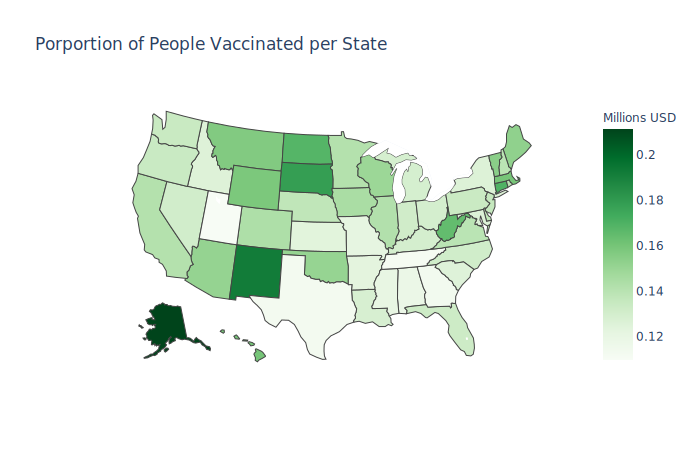

In [14]:
for i,j in state_code.iterrows():
    most_recent.loc[most_recent.state == state_code.loc[i]['State'], ['state']] = state_code.loc[i]['Abbreviation']


pio.renderers

fig = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion vaccination'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = 'Porportion of People Vaccinated per State',
    geo_scope='usa', # limite map scope to USA
)

fig.show(renderer="svg")

In [15]:
most_recent['proportion increase'] = most_recent['positive increase']/most_recent['2020 population']
most_recent['proportion positive'] = most_recent['positive']/most_recent['2020 population']

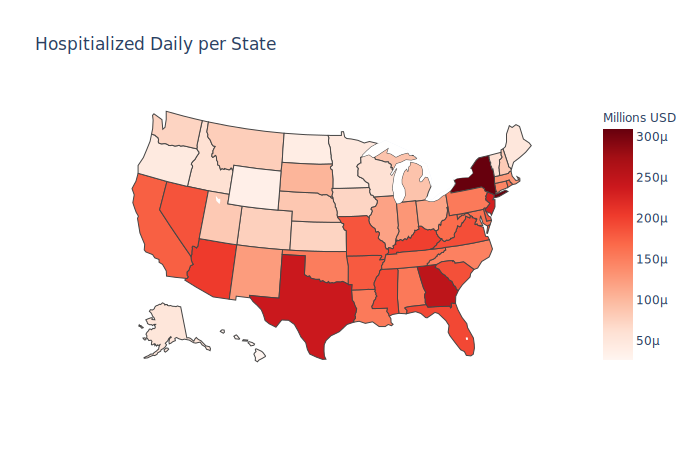

In [16]:
most_recent['proportion hospitalized'] = most_recent['hospitalized currently']/most_recent['2020 population']
fig2 = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion hospitalized'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
))

fig2.update_layout(
    title_text = 'Hospitialized Daily per State',
    geo_scope='usa', # limite map scope to USA
)

fig2.show(renderer="svg")

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[Text(0.5, 1.0, 'Number of People Vaccinated Daily in New York')]

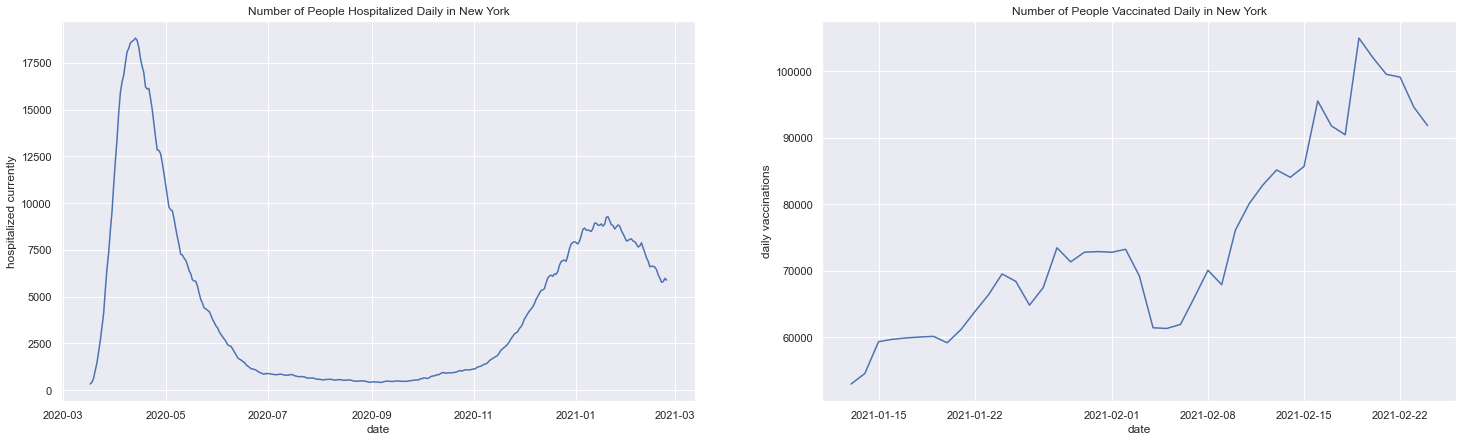

In [21]:
new_york_df = merged_data[merged_data['state'] == 'New York']
sns.set(rc={'figure.figsize':(25,7)})
new_york_df['date'] = pd.to_datetime(new_york_df['date'])
new_york_df2 = new_york_df[(new_york_df['date'] >= '2021-01-12')]
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=new_york_df).set(title='Number of People Hospitalized Daily in New York')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='daily vaccinations', data=new_york_df).set(title='Number of People Vaccinated Daily in New York')

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[Text(0.5, 1.0, 'Number of People Vaccinated Daily in Texas')]

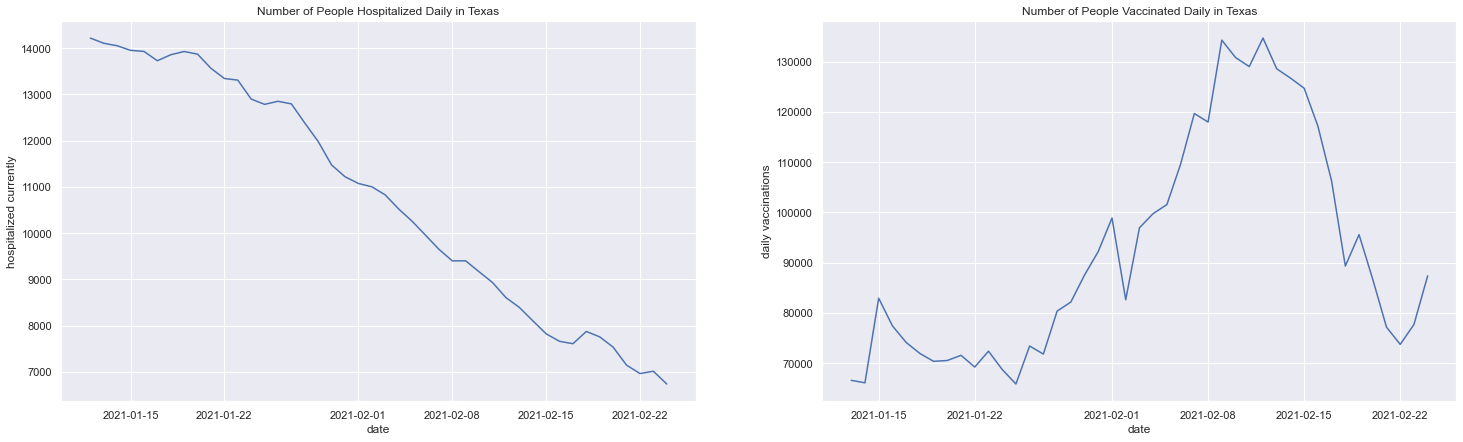

In [18]:
texas_df = merged_data[merged_data['state'] == 'Texas']
texas_df['date'] = pd.to_datetime(texas_df['date'])
texas_df = texas_df[(texas_df['date'] >= '2021-01-12')]
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=texas_df).set(title='Number of People Hospitalized Daily in Texas')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='daily vaccinations', data=texas_df).set(title='Number of People Vaccinated Daily in Texas')

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[Text(0.5, 1.0, 'Number of People Vaccinated Daily in Utah')]

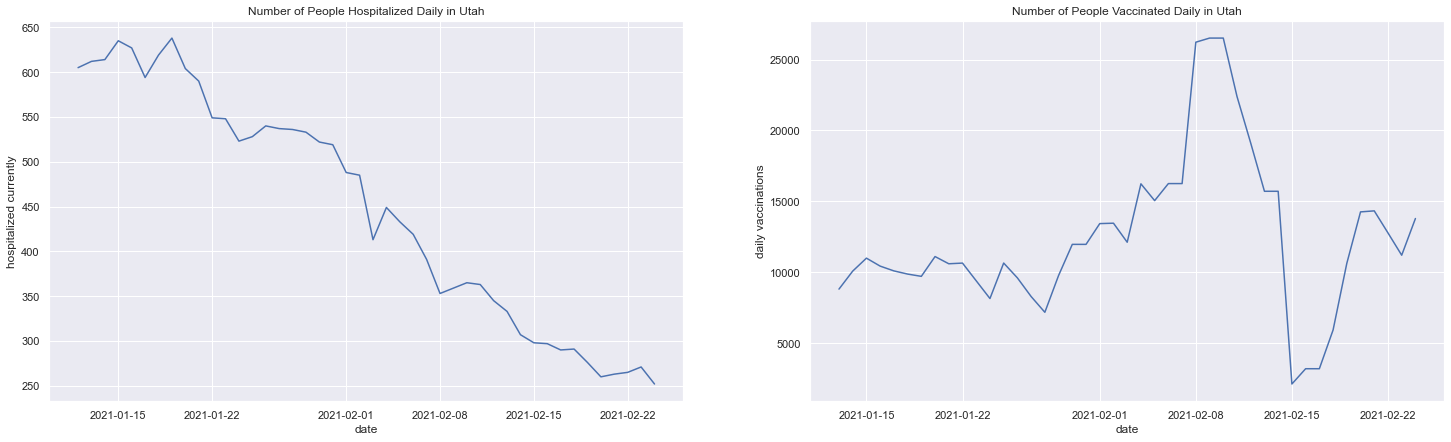

In [20]:
utah_df = merged_data[merged_data['state'] == 'Utah']
utah_df['date'] = pd.to_datetime(utah_df['date'])
utah_df = utah_df[(utah_df['date'] >= '2021-01-12')]
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=utah_df).set(title='Number of People Hospitalized Daily in Utah')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='daily vaccinations', data=utah_df).set(title='Number of People Vaccinated Daily in Utah')